In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
folder_path = "/content/drive/MyDrive/DA_FINAL/full_dataset.csv"

In [56]:
data = pd.read_csv(folder_path, parse_dates=['datetime'])
data

,datetime,day_of_week,day_name,is_weekend,month,month_name,month_abbr,season,day_sin,day_cos,...,EMA_20,EMA_50,EMA_200,RSI,ATR,MACD,MACD_Signal,Bollinger_Upper,Bollinger_Mid,Bollinger_Lower
0,2023-05-16 13:30:00,1,Tuesday,0,5,May,May,Spring,0.000000,1.000000,...,167.860345,167.706158,172.087043,33.774361,2.083642,-0.500352,-0.287061,171.839875,168.381561,164.923247
1,2023-05-16 14:30:00,1,Tuesday,0,5,May,May,Spring,0.781831,0.623490,...,167.928884,167.740426,172.052147,43.853172,2.046499,-0.375113,-0.304671,171.820326,168.367776,164.915227
2,2023-05-16 15:30:00,1,Tuesday,0,5,May,May,Spring,0.974928,-0.222521,...,167.976608,167.767468,172.016105,52.002776,1.957099,-0.284683,-0.300673,171.769824,168.334251,164.898679
3,2023-05-16 16:30:00,1,Tuesday,0,5,May,May,Spring,0.433884,-0.900969,...,168.009017,167.789014,171.979297,49.985752,1.924599,-0.219611,-0.284461,171.680061,168.280591,164.881121
4,2023-05-16 17:30:00,1,Tuesday,0,5,May,May,Spring,-0.433884,-0.900969,...,167.912910,167.758068,171.929751,46.388740,1.981028,-0.271186,-0.281806,171.484852,168.133585,164.782318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,2025-04-01 15:30:00,1,Tuesday,0,4,April,Apr,Spring,0.433884,-0.900969,...,264.526150,263.198399,277.892654,59.160493,6.124487,-0.571967,-2.179617,280.914274,263.504205,246.094135
3273,2025-04-01 16:30:00,1,Tuesday,0,4,April,Apr,Spring,-0.433884,-0.900969,...,265.365413,263.596046,277.847338,58.979143,6.220922,0.198447,-1.704004,280.403496,263.368125,246.332755
3274,2025-04-01 17:30:00,1,Tuesday,0,4,April,Apr,Spring,-0.974928,-0.222521,...,265.792517,263.841300,277.767763,54.457192,6.485207,0.521509,-1.258901,278.825213,262.950625,247.076037
3275,2025-04-01 18:30:00,1,Tuesday,0,4,April,Apr,Spring,-0.781831,0.623490,...,266.102752,264.045562,277.681019,55.231852,6.568541,0.704859,-0.866149,278.149584,262.741624,247.333664


# 1 Day Ahead Look

In [48]:
data['target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
data.dropna(inplace=True)

In [49]:
features = ['Close', 'Volume', 'RSI', 'MACD', 'ATR', 'SMA_20', 'EMA_20',
            'Bollinger_Upper', 'Bollinger_Lower', 'day_sin', 'day_cos']
target = 'target'

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

In [50]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30  # Lookback window
X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [51]:
# Train-test split (75%-25%)
split = int(0.75 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [52]:
model = Sequential([
    LSTM(75, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Train Accuracy: {train_acc:.2%}, Test Accuracy: {test_acc:.2%}")

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.1510 - loss: 0.6894 - val_accuracy: 0.2857 - val_loss: 0.5843
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2821 - loss: 0.4441 - val_accuracy: 0.2857 - val_loss: 0.3504
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.2753 - loss: 0.3556 - val_accuracy: 0.2857 - val_loss: 0.3457
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2731 - loss: 0.3567 - val_accuracy: 0.2857 - val_loss: 0.3375
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2873 - loss: 0.3522 - val_accuracy: 0.2857 - val_loss: 0.3462
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.2835 - loss: 0.3417 - val_accuracy: 0.2857 - val_loss: 0.3326
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.2993 - loss: 0.3351 - val_accuracy: 0.2857 - val_loss: 0.3336
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.2975 - loss: 0.3361 - val_accuracy: 0.2857 - v

In [54]:
# Predict on test set (ensure output is 1D)
test_predictions = model.predict(X_test).flatten()  # Removes extra dimension
binary_predictions = (test_predictions > 0.5).astype(int)  # Convert to 0/1

# Align dates and prices with predictions
start_idx = split + SEQ_LENGTH + 1
test_dates = data['datetime'].values[start_idx : start_idx + len(binary_predictions)]
test_close = data['Close'].values[start_idx : start_idx + len(binary_predictions)]

# Create DataFrame
results = pd.DataFrame({
    'datetime': test_dates,
    'actual_close': test_close,
    'prediction': binary_predictions,  # Now 1D
    'signal': np.where(binary_predictions == 1, 1, -1)  # Buy=1, Sell=-1
})

# Calculate returns
results['daily_return'] = results['actual_close'].pct_change()
results['strategy_return'] = results['signal'].shift(1) * results['daily_return']
results['cumulative_strategy'] = (1 + results['strategy_return']).cumprod()

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


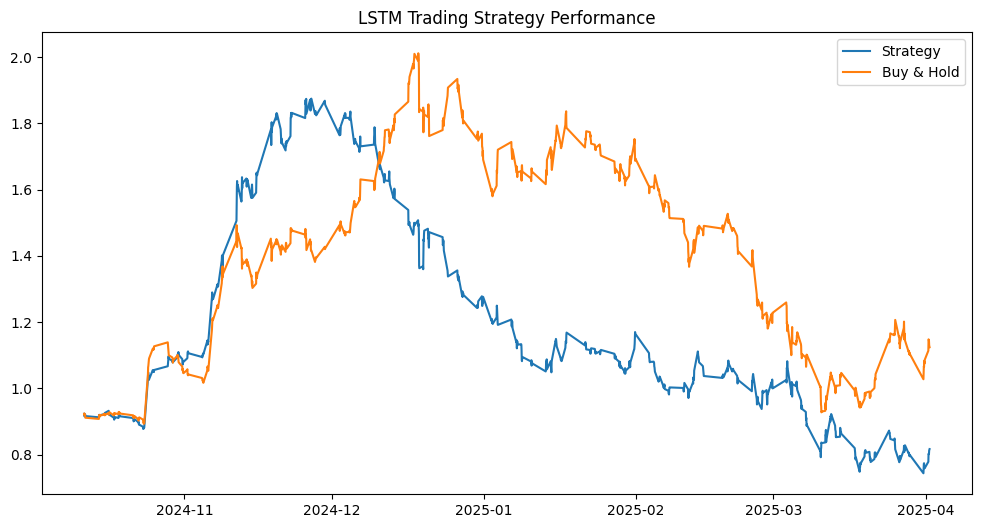

Total Return: -18.28%
Win Rate: 48.09%


In [55]:
# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot(results['datetime'], results['cumulative_strategy'], label='Strategy')
plt.plot(results['datetime'], (1 + results['daily_return']).cumprod(), label='Buy & Hold')
plt.legend()
plt.title('LSTM Trading Strategy Performance')
plt.show()

# Performance metrics
total_return = results['cumulative_strategy'].iloc[-1] - 1
win_rate = (results[results['strategy_return'] > 0]['strategy_return'].count() /
           results['strategy_return'].count())
print(f"Total Return: {total_return:.2%}")
print(f"Win Rate: {win_rate:.2%}")

# 10 Day Ahead look

In [56]:
# Create a 10-day forward return target
data['future_close'] = data['Close'].shift(-10)
data['target_10day'] = (data['future_close'] > data['Close']).astype(int)
data.dropna(inplace=True)  # Remove last 10 rows with NaN targets

In [61]:
def create_sequences(data, seq_length, lookahead, target_column):
    X, y = [], []
    for i in range(len(data) - seq_length - lookahead):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length + lookahead - 1, target_column])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30  # Lookback window
LOOKAHEAD = 10   # Prediction horizon
X, y = create_sequences(scaled_data, SEQ_LENGTH, LOOKAHEAD, target_column=-1)

In [62]:
def create_sequences(data, seq_length, lookahead, target_column):
    X, y = [], []
    for i in range(len(data) - seq_length - lookahead):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length + lookahead - 1, target_column])
    return np.array(X), np.array(y)


In [63]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Train Accuracy: {train_acc:.2%}, Test Accuracy: {test_acc:.2%}")

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.1626 - loss: 0.6920 - val_accuracy: 0.2857 - val_loss: 0.6372
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.2739 - loss: 0.4902 - val_accuracy: 0.2857 - val_loss: 0.3525
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.2742 - loss: 0.3607 - val_accuracy: 0.2857 - val_loss: 0.3389
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.2812 - loss: 0.3456 - val_accuracy: 0.2857 - val_loss: 0.3388
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.2822 - loss: 0.3460 - val_accuracy: 0.2857 - val_loss: 0.3322
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.2767 - loss: 0.3453 - val_accuracy: 0.2857 - val_loss: 0.3312
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.2791 - loss: 0.3427 - val_accuracy: 0.2857 - val_loss: 0.3386
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.2868 - loss: 0.3428 - val_accuracy: 0.2857 - 

In [67]:
test_predictions = (model.predict(X_test) > 0.5).astype(int)
test_dates = data['datetime'].iloc[split+SEQ_LENGTH+LOOKAHEAD-1:split+SEQ_LENGTH+LOOKAHEAD-1+len(X_test)]
actual_10day_moves = data['target_10day'].iloc[split+SEQ_LENGTH+LOOKAHEAD-1:split+SEQ_LENGTH+LOOKAHEAD-1+len(X_test)]

test_predictions = test_predictions[:794]


results = pd.DataFrame({
    'datetime': test_dates,
    'predicted_10day_rise': test_predictions.flatten(),
    'actual_10day_rise': actual_10day_moves.values
})

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [5]:
def prepare_data(df, look_back=60, forecast_horizon=10):
    features = ['day_sin', 'day_cos', 'Open', 'High', 'Low', 'Close', 'Volume',
                'VWAP', 'OBV', 'Cumulative_Return', 'SMA_5', 'SMA_20', 'SMA_50',
                'SMA_200', 'EMA_5', 'EMA_20', 'EMA_50', 'EMA_200', 'RSI', 'ATR',
                'MACD', 'MACD_Signal', 'Bollinger_Upper', 'Bollinger_Mid', 'Bollinger_Lower']

    target = 'Close'

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[features])
    scaled_target = scaler.fit_transform(df[[target]])

    X, y = [], []
    for i in range(len(df) - look_back - forecast_horizon):
        X.append(scaled_data[i:(i + look_back)])
        y.append(scaled_target[i + look_back + forecast_horizon - 1, 0])

    X, y = np.array(X), np.array(y)

    return X, y, scaler

In [6]:
def train_test_split(df):
    split_idx = int(len(df) * 0.75)
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    return train_df, test_df

In [7]:
# 3. Build LSTM Model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [57]:
def main():
    look_back = 30
    forecast_horizon = 10

    train_df, test_df = train_test_split(data)

    X_train, y_train, scaler = prepare_data(train_df, look_back, forecast_horizon)

    X_test, y_test, _ = prepare_data(test_df, look_back, forecast_horizon)

    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train,
                       epochs=20,
                       batch_size=32,
                       validation_split=0.2,
                       callbacks=[early_stop],
                       verbose=1)

    test_predictions = model.predict(X_test)

    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
    print(f"Test RMSE: {rmse}")

    signals = []
    for i in range(1, len(test_predictions)):
        if test_predictions[i] > test_predictions[i-1]:
            signals.append('Buy')
        else:
            signals.append('Sell')
    print(y_test_actual[1:-9].shape)
    print(test_predictions[1:-9].shape)
    signals = signals[0:-9]
    print(len(signals))

    test_dates = test_df.index[look_back + forecast_horizon:-forecast_horizon]
    print(test_dates.shape)
    signal_df = pd.DataFrame({
        'Date': test_dates,
        'Actual_Close': y_test_actual[1:-9].flatten(),
        'Predicted_Close': test_predictions[1:-9].flatten(),
        'Signal': signals
    })

    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, y_test_actual[1:-9], label='Actual Close')
    plt.plot(test_dates, test_predictions[1:-9], label='Predicted Close', alpha=0.7)

    buy_signals = signal_df[signal_df['Signal'] == 'Buy']
    sell_signals = signal_df[signal_df['Signal'] == 'Sell']
    plt.scatter(buy_signals['Date'], buy_signals['Actual_Close'],
                color='green', label='Buy Signal', marker='^', alpha=1)
    plt.scatter(sell_signals['Date'], sell_signals['Actual_Close'],
                color='red', label='Sell Signal', marker='v', alpha=1)

    plt.title(f'Stock Price Prediction with {forecast_horizon}-Day Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return signal_df


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 0.0517 - val_loss: 0.0075
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.0067 - val_loss: 0.0091
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.0059 - val_loss: 0.0076
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.0057 - val_loss: 0.0106
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.0061 - val_loss: 0.0068
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0055 - val_loss: 0.0074
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0051 - val_loss: 0.0068
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - los

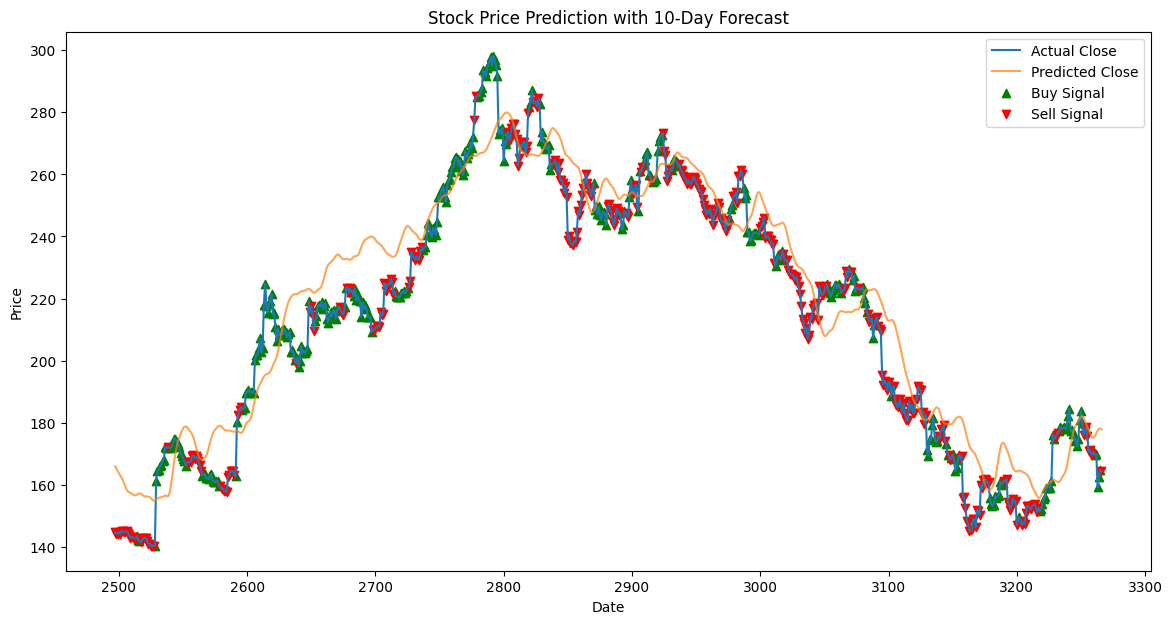

In [58]:
if __name__ == "__main__":
    trading_signals = main()